<a href="https://colab.research.google.com/github/aysebren/car_park_detection/blob/master/ModelWithPKandSave.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

In [ ]:
pip install -U --force-reinstall --no-dependencies git+https://github.com/datumbox/keras@bugfix/trainable_bn

In [ ]:
!pip install livelossplot

In [ ]:
from google.colab import drive, files
import keras
import keras.utils
from keras.applications.resnet50 import ResNet50
from keras.preprocessing import image
from keras.applications.resnet50 import preprocess_input, decode_predictions
from keras.models import Model
import numpy as np
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.python.keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense, BatchNormalization,GlobalAveragePooling2D
from keras.optimizers import SGD
from keras.optimizers import Adadelta
from keras import backend as K

In [ ]:

plot_losses = livelossplot.PlotLossesKeras()

IMAGE_SIZE = 224
IMAGE_WIDTH, IMAGE_HEIGHT = IMAGE_SIZE, IMAGE_SIZE
EPOCHS = 30
BATCH_SIZE = 64
TEST_SIZE = 30
seed=42
input_shape = (IMAGE_WIDTH, IMAGE_HEIGHT, 3)

model = Sequential()
K.set_learning_phase(1)
np.random.seed(seed)
base_model = ResNet50(weights='imagenet', include_top=False)

# for layer in model.layers[:140]:
#    layer.trainable = False

# for layer in model.layers[140:]:
#    layer.trainable = True


alpha = 0.00002  # weight decay coefficient

for layer in model.layers:
    if isinstance(layer, keras.layers.Conv2D) or isinstance(layer, keras.layers.Dense):
        layer.add_loss(lambda: keras.regularizers.l2(alpha)(layer.kernel))
    if hasattr(layer, 'bias_regularizer') and layer.use_bias:
        layer.add_loss(lambda: keras.regularizers.l2(alpha)(layer.bias))

initial_lrate=0.01
iteration=200
decay=0.01
lrate = initial_lrate * (1 / (1 + decay * iteration))

x = base_model.output
x = GlobalAveragePooling2D(data_format='channels_last')(x)

#x = Dropout(0.7)(x)
x = Dense(2, activation='softmax')(x)

model = Model(base_model.input, x)

model.compile(loss='categorical_crossentropy',
            optimizer=SGD(lr=lrate),
            metrics=['accuracy'])

In [ ]:


#path = "/content/drive/My Drive/CNRPark-Patches-150x150/"
path = "/content/drive/My Drive/pklotmix/"
train_data_dir = path + "train1"
valid_data_dir = path + "validation"


# Data augmentation

training_data_generator = ImageDataGenerator(
    preprocessing_function=keras.applications.resnet50.preprocess_input,
    rescale=1./255,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True)

# Data preparation
training_generator = training_data_generator.flow_from_directory(
    train_data_dir,
    target_size=(IMAGE_WIDTH, IMAGE_HEIGHT),
    batch_size=BATCH_SIZE,
    class_mode="categorical")


# Validation Data augmentation
valid_data_generator = ImageDataGenerator(
    preprocessing_function=keras.applications.resnet50.preprocess_input,
    rescale=1./255)

# Validation Data preparation
valid_generator = training_data_generator.flow_from_directory(
    valid_data_dir,
    target_size=(IMAGE_WIDTH, IMAGE_HEIGHT),
    batch_size=BATCH_SIZE,
    class_mode="categorical")




Found 17160 images belonging to 2 classes.
Found 5038 images belonging to 2 classes.


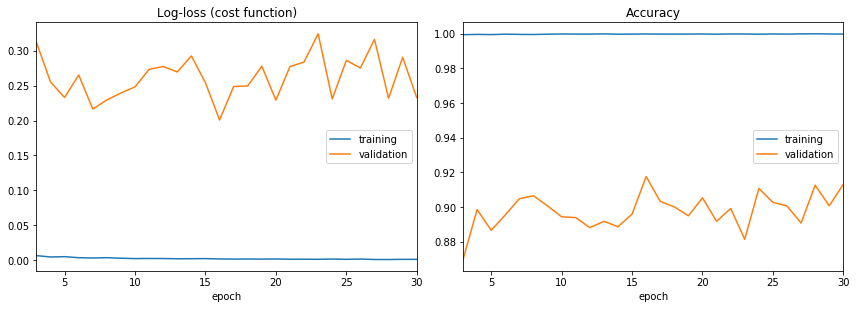

Log-loss (cost function):
training   (min:    0.001, max:    0.050, cur:    0.001)
validation (min:    0.197, max:    0.324, cur:    0.233)

Accuracy:
training   (min:    0.991, max:    1.000, cur:    1.000)
validation (min:    0.870, max:    0.917, cur:    0.913)


In [ ]:
K.set_learning_phase(1)
history = model.fit_generator(
    training_generator,
    steps_per_epoch=len(training_generator.filenames) // BATCH_SIZE,
    epochs=EPOCHS,
    callbacks=[plot_losses],
    validation_data = valid_generator,
    validation_steps = 30,
    verbose=1)


In [ ]:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# 1. Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

# 2. Save Keras Model or weights on google drive

# create on Colab directory
model.save('mymodelpk.h5')
model_file = drive.CreateFile({'title' : 'mymodelpk.h5'})
model_file.SetContentFile('mymodelpk.h5')
model_file.Upload()

# download to google drive
drive.CreateFile({'id': model_file.get('id')})

In [ ]:
model.save_weights('mymodelpk_weights.h5')
weight_file = drive.CreateFile({'title' : 'mymodelpk_weights.h5'})
weight_file.SetContentFile('mymodelpk_weights.h5')
weight_file.Upload()

# download to google drive
drive.CreateFile({'id': weight_file.get('id')})

In [ ]:
K.set_learning_phase(0)
test_data_dir = "/content/drive/My Drive/pklotmix/test/"
#test_data_dir = "/content/drive/My Drive/test/"
test_data_generator = ImageDataGenerator(rescale=1./255,preprocessing_function=keras.applications.resnet50.preprocess_input)
test_generator = test_data_generator.flow_from_directory(
    test_data_dir,
    target_size=(224, 224),
    batch_size=2,
    class_mode="categorical",
    shuffle=False)

Found 2244 images belonging to 2 classes.


In [ ]:
score=model.evaluate_generator(test_generator,steps=len(test_generator.filenames)//8)

print(score[0])
print(score[1])

0.02109833694744988
0.9982142857142857


In [ ]:
test_generator.reset()

In [ ]:
import keras
from keras import backend as K
from keras.preprocessing.image import ImageDataGenerator
K.set_learning_phase(0)
#test_data_dir = "/content/drive/My Drive/pklotmix/test/"
test_data_dir = "/content/drive/My Drive/test/"
test_data_generator = ImageDataGenerator(rescale=1./255,preprocessing_function=keras.applications.resnet50.preprocess_input)
test_generator = test_data_generator.flow_from_directory(
    test_data_dir,
    target_size=(224, 224),
    batch_size=2,
    class_mode="categorical",
    shuffle=False)

Found 2518 images belonging to 2 classes.


In [ ]:
score=model.evaluate_generator(test_generator,steps=len(test_generator.filenames)//128)

print(score[0])
print(score[1])

0.09297746763025459
0.9736842105263158
